In [1]:
import numpy as np
import scipy
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import collections
from datetime import datetime, timedelta

%matplotlib inline


# First Try

In [3]:
class Center:

  def __init__(self, lambdas, mus, sigmas):
    self.lambdas = lambdas
    self.mus = mus
    self.sigmas = sigmas
    self.guassians = [scipy.stats.norm(mu, sigma) for mu, sigma in zip(mus, sigmas)]

  def get_prob(self, x_list):
    p = np.full(x_list.shape, 0.0)
    for i in range(len(self.lambdas)):
      for j in range(x_list.shape[0]):
        p[j] += self.lambdas[i] * self.guassians[i].pdf(x_list[j])
    return p

  def mu_gradient(self, x_list, index):
    grad = np.full(x_list.shape, 0.0)
    for i, x in enumerate(x_list):
      grad[i] = self.lambdas[index] * self.guassians[index].pdf(x) * ((x-self.mus[index]) / self.sigmas[index]**2)
    return grad

  def sigma_gradient(self, x_list, index):
    grad = np.full(x_list.shape, 0.0)
    for i, x in enumerate(x_list):
      grad[i] = self.lambdas[index] * self.guassians[index].pdf(x) * (-1.0 / self.sigmas[index] + ((x-self.mus[index])**2)/(self.sigmas[index]**3))
    return grad

  def lambda_gradient(self, x_list, index):
    grad = np.full(x_list.shape, 0.0)
    for i, x in enumerate(x_list):
      grad[i] = self.guassians[index].pdf(x)
    return grad

  def gradient(self, var_name, x_list, index):
    if var_name == 'mu':
      return self.mu_gradient(x_list, index)
    elif var_name == 'sigma':
      return self.sigma_gradient(x_list, index)
    return self.lambda_gradient(x_list, index)

class Point:

  def __init__(self, samples, bandwidth=0.2):
    self.kde = KernelDensity(bandwidth=bandwidth)
    self.kde.fit(samples[:, np.newaxis])

  def get_sample(self, size):
    return np.asarray(self.kde.sample(size)).reshape(-1)

  def get_prob(self, samples):
    log_pdf = self.kde.score_samples(samples[:, np.newaxis])
    return np.exp(log_pdf)

def get_KL(point, center, sample_size=1000):
  point_sample = point.get_sample(sample_size)
  point_prob = point.get_prob(point_sample)
  center_prob = center.get_prob(point_sample)
  return np.sum(np.log(point_prob/center_prob)) / sample_size

def get_objective_gradient(var_name, points, center, points_center_prob, sample_size=1000):
  index_num = center.mus.shape[0]
  grads = np.full(index_num, 0.0)
  for index in range(index_num):
    for i, point in enumerate(points):
      point_sample = point.get_sample(sample_size)
      grads[index] += np.sum(points_center_prob[i] * (-1.0 * center.gradient(var_name, point_sample, index)) / center.get_prob(point_sample))
  return grads

def get_objective_function(points, centers, points_centers_prob):
  res = 0.0
  for i, p in enumerate(points):
    for j, c in enumerate(centers):
      res += points_centers_prob[i,j] * get_KL(p,c)
  return res

def gradient_descent(points, centers, points_centers_prob, epoch_num=10, learning_rate=0.01):
  for epoch in range(epoch_num):
    for i, center in enumerate(centers):
      points_center_prob = np.asarray(points_centers_prob[:,i]).reshape(-1)
      mu_gradients = get_objective_gradient('mu', points, center, points_center_prob)
      sigma_gradients = get_objective_gradient('sigma', points, center, points_center_prob)
      lambda_gradients = get_objective_gradient('lambda', points, center, points_center_prob)
      center.mus -= learning_rate * mu_gradients
      center.sigmas -= learning_rate * sigma_gradients
      center.lambdas -= learning_rate * lambda_gradients
      center.lambdas = center.lambdas / np.sum(center.lambdas)
    print('Epoch: {}, obj func: {}'.format(epoch, get_objective_function(points, centers, points_centers_prob)))

def get_points_centers_prob(points, centers):
  kls = np.full((points.shape[0], centers.shape[0]), 0.0)
  for i, p in enumerate(points):
    for j, c in enumerate(centers):
      kls[i,j] = get_KL(p, c)
    kls[i] = scipy.special.softmax(-1.0 * kls[i])
  return kls

def EM(points, centers, epoch_num=10):
  for epoch in range(epoch_num):
    points_centers_prob = get_points_centers_prob(points, centers)
    gradient_descent(points, centers, points_centers_prob)

In [0]:
# center = Center(np.array([0.5, 0.5]), np.array([0.0, 2.0]), np.array([1.0, 1.0]))
center1 = Center(np.array([1.0]), np.array([0.0]), np.array([1.0]))
center2 = Center(np.array([1.0]), np.array([2.0]), np.array([1.0]))

In [0]:
point1 = Point(np.random.normal(0.0, 1.0, 1000))
point2 = Point(np.random.normal(2.0, 1.0, 1000))

In [0]:
ps = get_points_centers_prob(np.array([point1, point2]), np.array([center1, center2]))
p = np.asarray(ps[:,0]).reshape(-1)
print(ps)
print(p)

[[0.87515619 0.12484381]
 [0.10872009 0.89127991]]
[0.87515619 0.10872009]


In [0]:
get_objective_function(np.array([point1, point2]), np.array([center1, center2]), ps)

0.4970177030637003

In [0]:
point1_sample = point1.get_sample(1000)
point2_sample = point2.get_sample(1000)
print(np.sum(center1.gradient('mu', point1_sample, 0)))
print(np.sum(center1.gradient('mu', point2_sample, 0)))

-2.970947780039056
103.9537410591031


In [0]:
get_objective_gradient('mu', np.array([point1, point2]), center1, np.array([0.0, 1.0]))

array([-2041.91890469])

In [0]:
gradient_descent(np.array([point1, point2]), np.array([center1, center2]), ps, epoch_num=10)

Epoch: 0, obj func: 0.5039035206661383
Epoch: 1, obj func: 0.4826145150589693
Epoch: 2, obj func: 0.4849778502996307
Epoch: 3, obj func: 0.4957785374289431
Epoch: 4, obj func: 0.4880363647592347
Epoch: 5, obj func: 0.4755985612000744
Epoch: 6, obj func: 0.4894875764219274
Epoch: 7, obj func: 0.496419150005675
Epoch: 8, obj func: 0.4730099802461569
Epoch: 9, obj func: 0.46990842543331085


In [0]:
print(center1.lambdas, center1.mus, center1.sigmas)
print(center2.lambdas, center2.mus, center2.sigmas)

[1.] [0.87395448] [2.66151026]
[1.] [0.34620462] [4.49089477]


# Second Try

In [6]:
def fix_array(arr):
    if arr.ndim == 1:
        return arr[:, np.newaxis]
    return arr

profile = {'point_init':[],
           'point_get_sample':[],
           'point_get_prob': [],
           'center_init':[],
           'center_get_sample':[],
           'center_get_prob': [],
           'center_update':[],
           'get_KL':[],
           'get_points_centers_prob':[],
           'get_objective_function':[]
           }

class Point:

    def __init__(self, samples, bandwidth=0.2):
        start = datetime.now()
        self.kde = KernelDensity(bandwidth=bandwidth)
        self.kde.fit(fix_array(samples))
        self.last_sample_prob = (None, -1.0)
        profile['point_init'].append(datetime.now()-start)

    def get_sample(self, size):
        start = datetime.now()
        sample = np.asarray(self.kde.sample(size))
        profile['point_get_sample'].append(datetime.now()-start)
        return sample

    def get_prob(self, samples):
        start = datetime.now()
        if np.array_equal(samples, self.last_sample_prob[0]):
            profile['point_get_prob'].append(datetime.now()-start)
            return self.last_sample_prob[1]
        log_pdf = self.kde.score_samples(fix_array(samples))
        prob = np.exp(log_pdf)
        self.last_sample_prob = (samples, prob)
        profile['point_get_prob'].append(datetime.now()-start)
        return prob

class Center:

    def __init__(self, points=None, points_center_prob=None, bandwidth=0.2):
        start = datetime.now()
        if points is not None:
            self.points = points
            self.points_center_prob = points_center_prob
        profile['center_init'].append(datetime.now()-start)

    def update(self, points, points_center_prob):
        start = datetime.now()
        self.points = points
        self.points_center_prob = points_center_prob
        profile['center_update'].append(datetime.now()-start)
    
  
    def get_sample(self, size):
        start = datetime.now()
        s = np.random.choice(range(len(self.points)), size=size, p=self.points_center_prob)
        counts = collections.Counter(s)
        samples = np.empty(self.points[0].get_sample(1).shape)
        for i in range(len(self.points)):
            if counts[i]>0:
                new_samples = self.points[i].get_sample(counts[i])
                samples = np.append(samples, new_samples, axis=0)
        profile['center_get_sample'].append(datetime.now()-start)
        return samples

    def get_prob(self, samples):
        start = datetime.now()
        prob = np.zeros(samples.shape[0])
        for i, p in enumerate(self.points):
            prob += (self.points_center_prob[i] * p.get_prob(samples))
        profile['center_get_prob'].append(datetime.now()-start)
        return prob

lower_bound, upper_bound = 10**-15, 10**5

def get_KL(point, center, sample_size=100):
    start = datetime.now()
    point_sample = point.get_sample(sample_size)
    # print(center.get_sample(2).shape)
    point_prob = point.get_prob(point_sample)
    center_prob = center.get_prob(point_sample)
    point_prob = np.clip(point_prob, lower_bound, upper_bound)
    center_prob = np.clip(center_prob, lower_bound, upper_bound)
    result = np.sum(np.log(point_prob/center_prob)) / sample_size
    profile['get_KL'].append(datetime.now()-start)
    return result

def get_points_centers_prob(points, centers, coef=-10.0):
    start = datetime.now()
    kls = np.full((len(points), len(centers)), 0.0)
    for i, p in enumerate(points):
        for j, c in enumerate(centers):
            kls[i,j] = get_KL(p, c)
    kls[i] = coef*kls[i]
    kls[i] = scipy.special.softmax(kls[i])
    profile['get_points_centers_prob'].append(datetime.now()-start)
    return kls

def get_objective_function(points, centers, points_centers_prob):
    start = datetime.now()
    res = 0.0
    for i, p in enumerate(points):
        for j, c in enumerate(centers):
            kl = get_KL(p,c)
            res += points_centers_prob[i,j] * kl
    profile['get_objective_function'].append(datetime.now()-start)
    return res

def get_precision_recall(ps):
    generated_clusters = np.zeros((ps.shape[0]))
    for i in range(ps.shape[0]):
        generated_clusters[i] = np.argmax(ps[i])+1

    tp, fn, fp, tn = 0,0,0,0
    for i in range(len(points)):
        for j in range(i+1,len(points)):
            if true_clusters[i] == true_clusters[j] and generated_clusters[i] == generated_clusters[j]:
                tp += 1
            if true_clusters[i] != true_clusters[j] and generated_clusters[i] == generated_clusters[j]:
                fp += 1
            if true_clusters[i] == true_clusters[j] and generated_clusters[i] != generated_clusters[j]:
                fn += 1
            if true_clusters[i] != true_clusters[j] and generated_clusters[i] != generated_clusters[j]:
                tn += 1
    precision = (float)(tp) / (tp + fp)
    recall = (float)(tp) / (tp + fn)
    acc = (float)(tp+tn)/(tp+tn+fp+fn)
    return precision, recall, acc

def get_convergence(ps, pre_ps):
    diff = np.abs(ps - pre_ps)
    np.min(diff)
    return np.min(diff)

In [6]:
mean = [0, 0]
cov = [[1, 0], [0, 1]]
p1 = Point(np.random.multivariate_normal(mean, cov, 100))
p2 = Point(np.random.multivariate_normal(mean, cov, 100))
p3 = Point(np.random.multivariate_normal(mean, cov, 100))
points = [p1,p2,p3]
centers_size = 1

In [7]:
point1 = Point(np.append(np.random.normal(0.0, 1.0, 500), np.random.normal(10.0, 1.0, 500)))
point2 = Point(np.random.normal(5.0, 1.0, 1000))
point3 = Point(np.random.normal(5.0, 1.0, 1000))
point4 = Point(np.append(np.append(np.random.normal(0.0, 1.0, 300), np.random.normal(5.0, 1.0, 300)), np.random.normal(10.0, 1.0, 300)))
points = [point1, point2, point3, point4]
centers_size = 3
true_clusters = np.array([0,1,1,2])

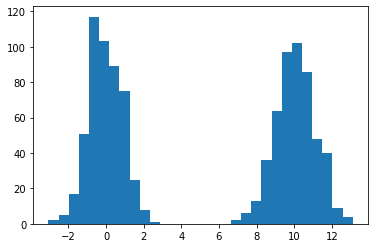

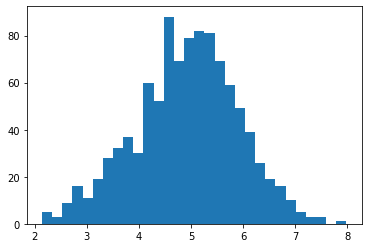

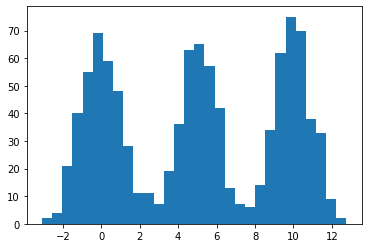

In [8]:
for p in [point1, point2, point4]:
    plt.hist(p.get_sample(1000), bins=30)
    plt.show()

In [7]:
points = []
for raw_point in raw_points[:10]:
    points.append(Point(raw_point))
centers_size = 5

In [8]:
len(points)

10

In [9]:
initial_centers = []

best_center_ind = 0
best_kl = sum([get_KL(p, points[0]) for p in points])
remained_centers = list(range(len(points)))
print('Find first initial center')
for i in range(1, len(points)):
    # print(i)
    new_kl = sum([get_KL(p, points[i]) for p in points])
    if new_kl < best_kl:
        best_kl = new_kl
        best_center_ind = i
initial_centers.append(Center(points=[points[best_center_ind]], points_center_prob=np.array([1.0])))
remained_centers.remove(best_center_ind)

Find first initial center


In [10]:
print('Find other initial centers')
for i in range(1, centers_size):
    print('find ' + str(i) + 'th center')
    best_center_ind = -1
    best_kl = np.float('inf')
    for ind in remained_centers:
        # print('try point:', ind)
        new_centers = initial_centers + [points[ind]]
        ps = get_points_centers_prob(points, new_centers)
        # print(i,ind, ps)
        new_kl = get_objective_function(points, new_centers, ps)
        if new_kl < best_kl:
            best_kl = new_kl
            best_center_ind = ind
    initial_centers.append(Center(points=[points[best_center_ind]], points_center_prob=np.array([1.0])))
    remained_centers.remove(best_center_ind)
centers = initial_centers

if initial_centers[0].get_sample(1).shape[1] <= 2:
    for i, c in enumerate(initial_centers):
        c_samples = c.get_sample(1000)
        if c_samples.shape[1] == 1:
            plt.hist(c_samples[:,0], bins=30)
        elif c_samples.shape[1] == 2:
            plt.scatter(c_samples[:,0],c_samples[:,1])
    plt.title('Center:' + str(i+1))
    plt.show()


Find other initial centers
find 1th center
find 2th center
find 3th center
find 4th center


In [11]:
# ps = np.zeros((len(points), len(centers)))
# for i in range(len(points)):
#   ps[i] = np.random.dirichlet(np.ones(len(centers)),size=1)[0]
precisions, recalls, accs = [], [], []
convs = []
ps = get_points_centers_prob(points, centers)

# print('initial probs:', ps)

ITER = 20
pre_ps = ps
for i in range(ITER):
    for j, c in enumerate(centers):
        c.update(points, np.asarray(ps[:,j]).reshape(-1)/np.sum(np.asarray(ps[:,j]).reshape(-1)))
    ps = get_points_centers_prob(points, centers)
    precision, recall, acc = get_precision_recall(ps)
    convergence = get_convergence(ps,pre_ps)
    pre_ps = ps
    convs.append(convergence)
    precisions.append(precision)
    recalls.append(recall)
    accs.append(acc)
    print('Iter: {}, Obj: {},new probs: {}'.format(i+1, get_objective_function(points, centers, ps), ps))
    print('########################')

Iter: 1, Obj: 87.90016167911493,new probs: [[8.04591972e-01 4.80903441e-01 6.24227717e-01 3.52055958e-01
  2.11157717e+00]
 [8.65854299e-01 2.42356984e+00 1.76349582e+00 2.55218970e+00
  4.40050601e-01]
 [8.15748390e-01 1.89618355e+00 1.40754627e+00 2.29023208e+00
  2.91176393e-01]
 [9.14980399e-01 5.49721566e-01 5.82295919e-01 4.20357641e-01
  2.46502796e+00]
 [8.75176552e-01 4.66502562e-01 4.26685995e-01 4.42233969e-01
  1.86637199e+00]
 [1.17103273e+00 2.33148571e+00 1.92002719e+00 2.68114150e+00
  7.31671189e-01]
 [1.25490622e+00 1.82260078e+00 1.72981755e+00 1.77863082e+00
  1.10487286e+00]
 [8.93712953e-01 1.23445333e+00 8.99839523e-01 1.18682057e+00
  5.44759252e-01]
 [8.93111296e-01 4.88091222e-01 5.67464009e-01 5.95847229e-01
  1.95940283e+00]
 [3.32032847e-03 2.36182515e-02 3.46646971e-01 6.26413379e-01
  1.06904143e-06]]
########################
Iter: 2, Obj: 58.46510974907208,new probs: [[1.08845848e+00 1.63038173e+00 1.57230642e+00 1.88635037e+00
  6.25459418e-01]
 [7.9587

Iter: 11, Obj: 41.50623636725968,new probs: [[8.92089401e-01 9.65995316e-01 9.22705088e-01 9.86645811e-01
  8.87189734e-01]
 [7.71540715e-01 1.03706445e+00 8.37767299e-01 6.81800818e-01
  9.10343507e-01]
 [7.82886523e-01 9.02902601e-01 8.78490719e-01 6.70320721e-01
  9.29175012e-01]
 [1.07307370e+00 1.01375376e+00 8.14615959e-01 8.11100073e-01
  9.37678495e-01]
 [1.01859378e+00 8.88846117e-01 8.97918301e-01 8.46134656e-01
  9.38334447e-01]
 [1.32933389e+00 1.32146038e+00 1.28952009e+00 1.26085999e+00
  1.41338084e+00]
 [1.06459422e+00 1.22534298e+00 1.20745990e+00 9.83766980e-01
  1.21225011e+00]
 [6.55887135e-01 7.29102090e-01 6.56802235e-01 6.66441098e-01
  4.93024333e-01]
 [1.09200723e+00 7.37821981e-01 9.28383561e-01 7.59473713e-01
  8.04968412e-01]
 [1.50694449e-03 9.72671436e-01 2.21550096e-02 2.55926802e-03
  1.10734196e-03]]
########################
Iter: 12, Obj: 41.63817814314687,new probs: [[8.95888392e-01 8.94831632e-01 9.21501555e-01 8.68315773e-01
  1.08140288e+00]
 [7.03

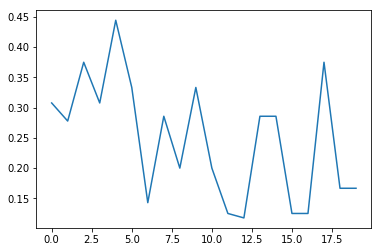

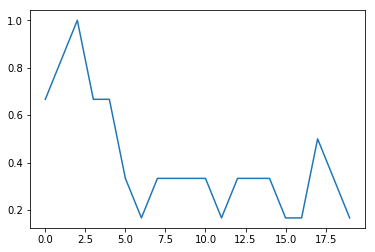

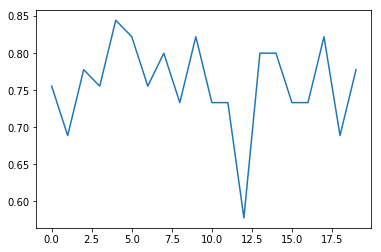

In [12]:
plt.plot(np.arange(0,len(precisions)),precisions)
plt.show()
plt.plot(np.arange(0,len(recalls)),recalls)
plt.show()
plt.plot(np.arange(0,len(accs)),accs)
plt.show()

In [13]:
print(precisions)
print(recalls)
print(accs)
print(convs)

[0.3076923076923077, 0.2777777777777778, 0.375, 0.3076923076923077, 0.4444444444444444, 0.3333333333333333, 0.14285714285714285, 0.2857142857142857, 0.2, 0.3333333333333333, 0.2, 0.125, 0.11764705882352941, 0.2857142857142857, 0.2857142857142857, 0.125, 0.125, 0.375, 0.16666666666666666, 0.16666666666666666]
[0.6666666666666666, 0.8333333333333334, 1.0, 0.6666666666666666, 0.6666666666666666, 0.3333333333333333, 0.16666666666666666, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.16666666666666666, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.16666666666666666, 0.16666666666666666, 0.5, 0.3333333333333333, 0.16666666666666666]
[0.7555555555555555, 0.6888888888888889, 0.7777777777777778, 0.7555555555555555, 0.8444444444444444, 0.8222222222222222, 0.7555555555555555, 0.8, 0.7333333333333333, 0.8222222222222222, 0.7333333333333333, 0.7333333333333333, 0.5777777777777777, 0.8, 0.8, 0.7333333333333333, 0.7333333333333333, 0.8222222222222222

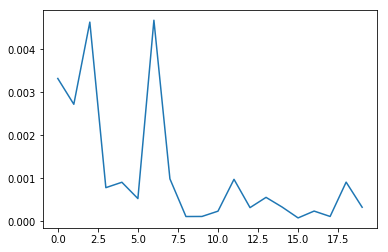

In [14]:
plt.plot(np.arange(len(convs)), convs)

In [15]:
for k,v in profile.items():
    res = timedelta(0)
    for v2 in v:
        res += v2
    print(k,':', res, ',', len(v))

point_init : 0:00:00.003429 , 10
point_get_sample : 0:00:00.267117 , 4152
point_get_prob : 0:00:09.410682 , 26300
center_init : 0:00:00.000004 , 5
center_get_sample : 0:00:00.000254 , 1
center_get_prob : 0:00:07.648228 , 3450
center_update : 0:00:00.000105 , 100
get_KL : 0:00:09.932287 , 4150
get_points_centers_prob : 0:00:04.928520 , 51
get_objective_function : 0:00:04.920795 , 50


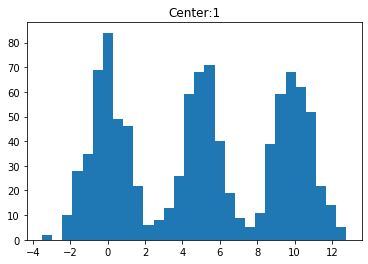

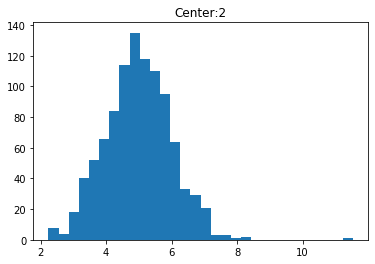

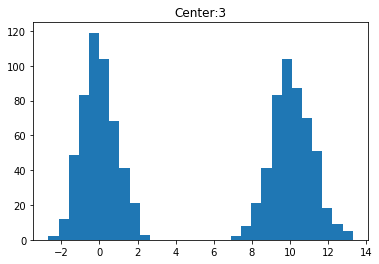

In [16]:
for i, c in enumerate(initial_centers):
    c_samples = c.get_sample(1000)
    if c_samples.shape[1] == 1:
        plt.hist(c_samples[:,0], bins=30)
    elif c_samples.shape[1] == 2:
        plt.scatter(c_samples[:,0],c_samples[:,1])
    plt.title('Center:' + str(i+1))
    plt.show()

In [5]:
import pandas as pd

true_clusters = pd.read_csv('dataset/movement/groups/MovementAAL_Paths.csv')[' path_ID'].to_numpy().tolist()
raw_points = []
for i in range(1,315):
    x = pd.read_csv('dataset/movement/dataset/MovementAAL_RSS_' + str(i) + '.csv').to_numpy()
    raw_points.append(x)

In [3]:
import random
combined = list(zip(raw_points, true_clusters))
random.shuffle(combined)
raw_points, true_clusters = zip(*combined)

In [25]:
len(raw_points)

314